<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W3/ungraded_labs/C4_W3_Lab_1_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Using a Simple RNN for forecasting

In this lab, you will start to use recurrent neural networks (RNNs) to build a forecasting model. In particular, you will:

* build a stacked RNN using `simpleRNN` layers
* use `Lambda` layers to reshape the input and scale the output
* use the Huber loss during training
* use batched data windows to generate model predictions

You will train this on the same synthetic dataset from last week so the initial steps will be the same. Let's begin!

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import time

## Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()



In [3]:
import pandas as pd
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\VIC.csv')
data.head

<bound method NDFrame.head of       Unnamed: 0        time   open   high    low  close   volume
0              0  2015-01-05  20.48  20.48  20.31  20.44   320790
1              1  2015-01-06  20.35  20.53  20.31  20.53   462360
2              2  2015-01-07  20.53  20.61  20.40  20.48   319600
3              3  2015-01-08  20.48  20.78  20.48  20.61   788420
4              4  2015-01-09  20.61  20.87  20.53  20.53   969330
...          ...         ...    ...    ...    ...    ...      ...
2421        2421  2024-09-13  42.90  42.95  42.50  42.90  1526300
2422        2422  2024-09-16  42.70  43.60  42.05  42.05  2005200
2423        2423  2024-09-17  42.05  43.20  42.05  42.90  2237700
2424        2424  2024-09-18  42.90  43.30  42.65  42.65  2746900
2425        2425  2024-09-19  42.80  43.20  42.70  43.00  1368900

[2426 rows x 7 columns]>

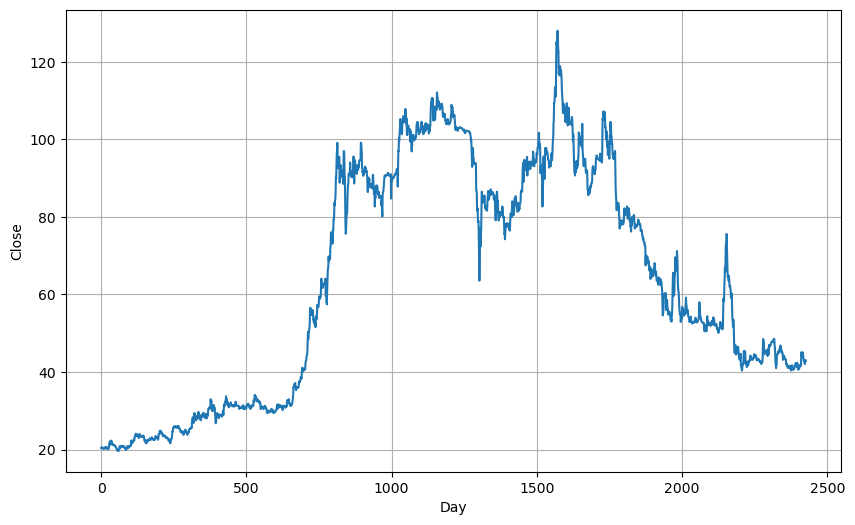

In [4]:
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\VIC.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time_step = np.array(time_step)
series = np.array(close)

# Preview the data
plot_series(time_step, series, xlabel='Day', ylabel='Close')

In [5]:
# Define the split time
split_time = 2000

# Get the train set 
time_train = time_step[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time_step[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 500
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [6]:
import time
start_time = time.time()
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)
end_time = time.time()
train_time_cls = end_time - start_time
print(f'Thời gian huấn luyện mô hình DNN: {train_time_cls:.4f} giây')

Epoch 1/100
62/62 [==============================] - 23s 151ms/step - loss: 16.7613 - mae: 17.2564
Epoch 2/100
62/62 [==============================] - 2s 23ms/step - loss: 8.9584 - mae: 9.4474
Epoch 3/100
62/62 [==============================] - 1s 21ms/step - loss: 3.1863 - mae: 3.6523
Epoch 4/100
62/62 [==============================] - 1s 19ms/step - loss: 3.1334 - mae: 3.5980
Epoch 5/100
62/62 [==============================] - 1s 21ms/step - loss: 3.6368 - mae: 4.1094
Epoch 6/100
62/62 [==============================] - 2s 24ms/step - loss: 3.3685 - mae: 3.8434
Epoch 7/100
62/62 [==============================] - 2s 26ms/step - loss: 3.5745 - mae: 4.0384
Epoch 8/100
62/62 [==============================] - 1s 20ms/step - loss: 4.1289 - mae: 4.5956
Epoch 9/100
62/62 [==============================] - 1s 14ms/step - loss: 4.3752 - mae: 4.8372
Epoch 10/100
62/62 [==============================] - 1s 18ms/step - loss: 3.9910 - mae: 4.4652
Epoch 11/100
62/62 [=========================

62/62 [==============================] - 1s 14ms/step - loss: 1.3898 - mae: 1.8198
Epoch 87/100
62/62 [==============================] - 1s 13ms/step - loss: 1.6111 - mae: 2.0283
Epoch 88/100
62/62 [==============================] - 1s 12ms/step - loss: 2.6688 - mae: 3.1265
Epoch 89/100
62/62 [==============================] - 1s 13ms/step - loss: 1.9007 - mae: 2.3456
Epoch 90/100
62/62 [==============================] - 1s 14ms/step - loss: 1.7783 - mae: 2.2105
Epoch 91/100
62/62 [==============================] - 1s 15ms/step - loss: 2.1947 - mae: 2.6203
Epoch 92/100
62/62 [==============================] - 1s 14ms/step - loss: 1.9551 - mae: 2.3910
Epoch 93/100
62/62 [==============================] - 1s 14ms/step - loss: 1.7959 - mae: 2.2415
Epoch 94/100
62/62 [==============================] - 1s 18ms/step - loss: 1.8240 - mae: 2.2617
Epoch 95/100
62/62 [==============================] - 1s 17ms/step - loss: 1.2953 - mae: 1.7261
Epoch 96/100
62/62 [==============================] -

In [7]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

14/14 [==============================] - 0s 10ms/step


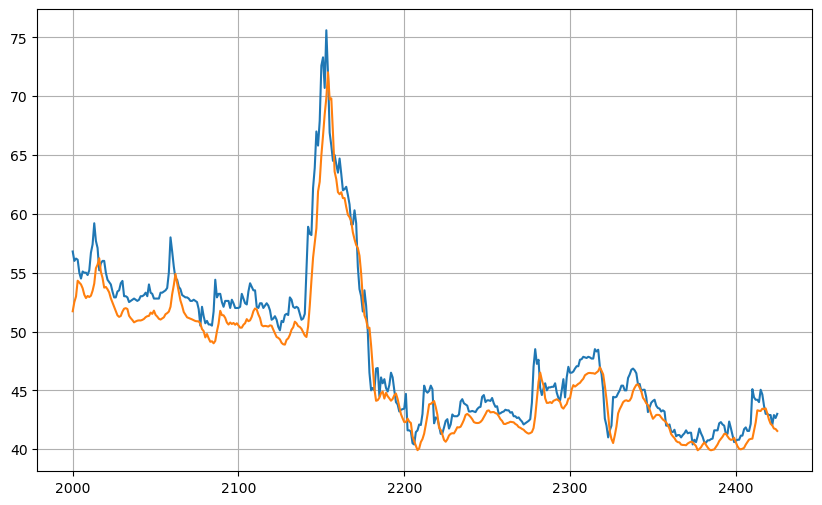

[51.71963  52.508385 52.97633  54.315983 54.163136 54.000385 53.67375
 53.124737 52.843742 53.02016  52.93218  53.043346 53.463047 54.074837
 55.377514 55.681282 56.228477 55.075497 54.55498  53.72769  53.788612
 53.58983  53.323956 52.822678 52.45763  52.11727  51.744526 51.37181
 51.244335 51.320045 51.68882  51.936954 51.98419  51.91409  51.336807
 51.135605 50.974857 50.78032  50.85693  50.92129  50.944458 50.93723
 50.988144 51.070805 51.217293 51.300663 51.325764 51.609005 51.496918
 51.77548  51.412384 51.267666 51.081795 51.01642  51.11161  51.20712
 51.470745 51.56107  51.69368  52.102047 53.169544 53.947224 54.892845
 54.108448 53.352272 52.630608 52.18755  51.65207  51.434547 51.205696
 51.142097 51.08797  51.02962  50.958412 50.890244 50.868713 50.861843
 50.667675 50.207073 50.035538 49.49778  49.78544  49.427723 49.12798
 49.170258 48.99706  49.20192  50.008923 50.664467 51.758545 51.390915
 51.380157 51.1562   50.764496 50.59224  50.76366  50.63819  50.726265
 50.573772 

In [8]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)
# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)